# Validate Webster with synthetic data

William Colgan May 11 2023

### Setup

In [34]:
library(pheatmap)
library(sn)
library(magrittr)
library(tidyverse)
source("./lib/helpers.R")

### Generate data

Code from webster paper

In [24]:
generate_skewed_dictionary <- function(n = 25, rho = 0.2) {
  #https://stats.stackexchange.com/questions/15011/generate-a-random-variable-with-a-defined-correlation-to-an-existing-variables
  n    # length of vector
  rho   # desired correlation = cos(angle)
  theta <- acos(rho)             # corresponding angle
  x1    <- -dsn(seq(-0.5, 1, length.out = num_cell_lines) %>% sample, xi = 0.1, omega = 0.3, alpha = 5)       # fixed given data
  x2    <- -dsn(seq(-0.5, 1, length.out = num_cell_lines) %>% sample, xi = 0.1, omega = 0.3, alpha = 5)
  # new random data
  X     <- cbind(x1, x2)         # matrix
  Xctr  <- scale(X, center=TRUE, scale=FALSE)   # centered columns (mean 0)

  Id   <- diag(n)                               # identity matrix
  Q    <- qr.Q(qr(Xctr[ , 1, drop=FALSE]))      # QR-decomposition, just matrix Q
  P    <- tcrossprod(Q)          # = Q Q'       # projection onto space defined by x1
  x2o  <- (Id-P) %*% Xctr[ , 2]                 # x2ctr made orthogonal to x1ctr
  Xc2  <- cbind(Xctr[ , 1], x2o)                # bind to matrix
  Y    <- Xc2 %*% diag(1/sqrt(colSums(Xc2^2)))  # scale columns to length 1

  x <- Y[ , 2] + (1 / tan(theta)) * Y[ , 1]     # final new vector
  cor(x1, x)                                    # check correlation = rho
  return(cbind(x1, x) %>% scale(center= T, scale = F))
}

# Set up synthetic cell lines and genes  ---------------------------------------------------
num_cell_lines <- 25
cl_names <- paste("Cell_Line", 1:num_cell_lines, sep = "_")

num_genes <- 60
gene_names <- paste("Gene", 1:num_genes, sep = "_")


gene_df <- tibble(Gene = gene_names,
                  Program = c(rep("1", 20), rep("2", 20), rep("Both", 20)) %>%
                    factor(levels = c("1", "2", "Both")))


seq(-0.1, 1.1, length.out = num_cell_lines)

dict_mat <- -generate_skewed_dictionary(num_cell_lines, rho = 0.25) %>% scale(center = T, scale = T)
colnames(dict_mat) <- c("Program 1","Program 2")

code_mat <- rbind(c(rep(2, 20), rep(0, 20), rep(1, 20)),
                  c(rep(0, 20), rep(2, 20), rep(1, 20)))

reconstruct_mat <- dict_mat %*% (code_mat)

noise_mat <- rnorm(length(reconstruct_mat), sd = 0.7) %>% matrix(dim(reconstruct_mat))

final_mat <- (reconstruct_mat + noise_mat)

[1] -1.000000e-01 -5.000000e-02  1.387779e-17  5.000000e-02  1.000000e-01
 [6]  1.500000e-01  2.000000e-01  2.500000e-01  3.000000e-01  3.500000e-01
[11]  4.000000e-01  4.500000e-01  5.000000e-01  5.500000e-01  6.000000e-01
[16]  6.500000e-01  7.000000e-01  7.500000e-01  8.000000e-01  8.500000e-01
[21]  9.000000e-01  9.500000e-01  1.000000e+00  1.050000e+00  1.100000e+00

Transciptional program dictionary

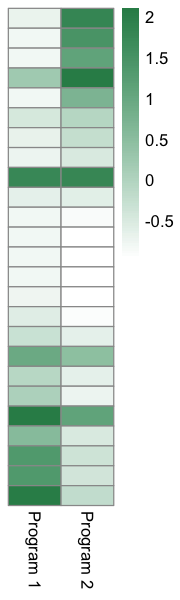

In [77]:
options(repr.plot.width=1.5, repr.plot.height=5)
pheatmap(dict_mat[(order(dict_mat[,1]-dict_mat[,2])),], cluster_cols = F, cluster_rows = F, colorRampPalette(c( "white","seagreen"))(100), 
    width = 1.5, height = 5)
pheatmap(dict_mat[(order(dict_mat[,1]-dict_mat[,2])),], cluster_cols = F, cluster_rows = F, colorRampPalette(c( "white","seagreen"))(100), 
    width = 1.5, height = 5,filename =  "./output/synthetic_data/synthetic_programs.pdf")

Perturbation loadings

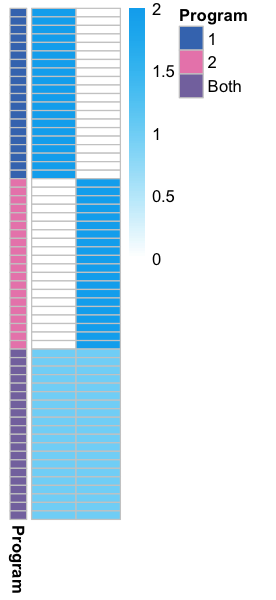

In [78]:
options(repr.plot.width=2.3, repr.plot.height=5)
#Loadings
pheatmap(code_mat %>% set_colnames(gene_names)  %>% t(), show_colnames = F,show_rownames = F, cluster_cols = F, cluster_rows = F,  colorRampPalette(c("white", "#00AEEF"))(100),
         annotation_row = gene_df %>% column_to_rownames("Gene"),
         annotation_colors = list(Program = c("1" = "#4278BC", "2" = "#EA89B8", "Both" = "#8575AD")),
         width = 2.3, height = 5, border_color = "gray80")
pheatmap(code_mat %>% set_colnames(gene_names)  %>% t(), show_colnames = F,show_rownames = F, cluster_cols = F, cluster_rows = F,  colorRampPalette(c("white", "#00AEEF"))(100),
         annotation_row = gene_df %>% column_to_rownames("Gene"),
         annotation_colors = list(Program = c("1" = "#4278BC", "2" = "#EA89B8", "Both" = "#8575AD")),
         width = 2.3, height = 5, border_color = "gray80",filename =  "./output/synthetic_data/synthetic_loadings.pdf")

Noisy matrix

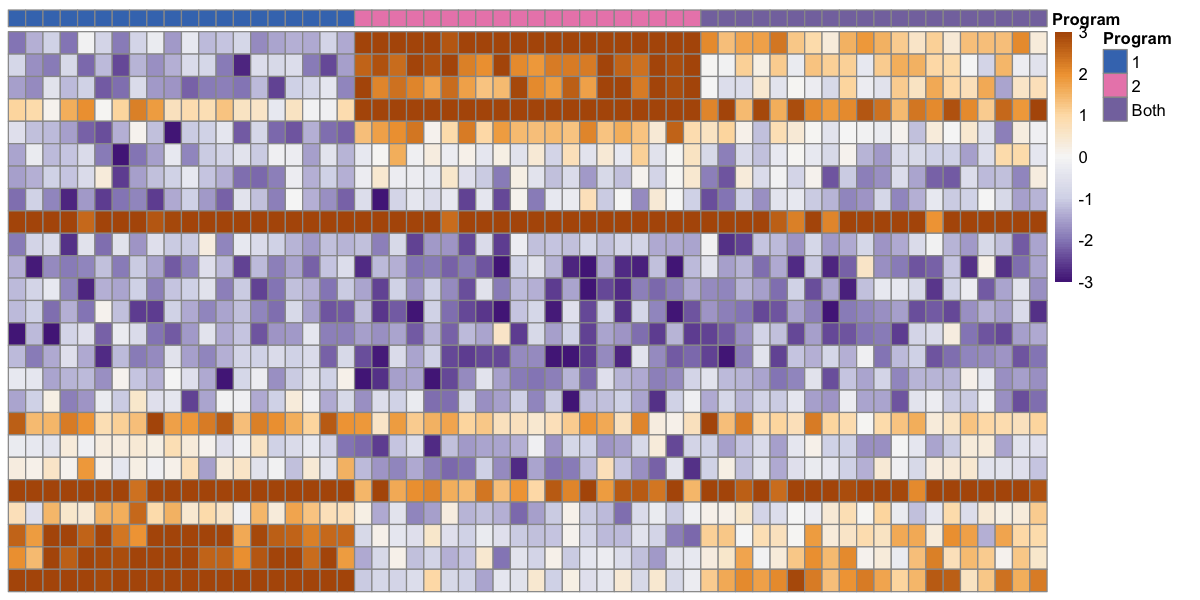

In [80]:
options(repr.plot.width=10, repr.plot.height=5)
pheatmap(final_mat %>% set_colnames(gene_names) %>%
           magrittr::extract(order(dict_mat[,1]-dict_mat[,2]),), show_colnames = F, cluster_cols = F, cluster_rows = F,
         annotation_col = gene_df %>% column_to_rownames("Gene"),
         annotation_colors = list(Program = c("1" = "#4278BC", "2" = "#EA89B8", "Both" = "#8575AD")),
         color = colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name = "PuOr")))(100),
         breaks = seq(-3, 3, length.out=101),
        width = 10, height = 4)
pheatmap(final_mat %>% set_colnames(gene_names) %>%
           magrittr::extract(order(dict_mat[,1]-dict_mat[,2]),), show_colnames = F, cluster_cols = F, cluster_rows = F,
         annotation_col = gene_df %>% column_to_rownames("Gene"),
         annotation_colors = list(Program = c("1" = "#4278BC", "2" = "#EA89B8", "Both" = "#8575AD")),
         color = colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name = "PuOr")))(100),
         breaks = seq(-3, 3, length.out=101),
        width = 10, height = 5,filename =  "./output/synthetic_data/synthetic_mat.pdf")

### Run Webster

In [73]:
export_for_matlab(final_mat, "./output/synthetic_example.csv")

```
DGRDL_wrapper('/Users/william/Projects/perturb-seq-webster/output/synthetic_example.csv', 'K', 2, 'T', 2, 'filename_out', '/Users/william/Projects/perturb-seq-webster/output/interim/test_synthetic.mat', 'num_neighbor_gene', 1)
```

In [60]:
temp  <- R.matlab::readMat("./output/interim/test_synthetic.mat")
recovered_dictionary <- as.matrix(temp$D)
recovered_loadings  <- as.matrix(temp$X)

recovered loadings

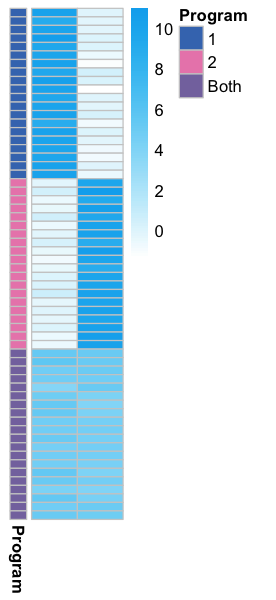

In [83]:
options(repr.plot.width=2.3, repr.plot.height=5)
pheatmap(recovered_loadings %>% set_colnames(gene_names)  %>% t(), show_colnames = F,show_rownames = F, cluster_cols = F, cluster_rows = F,  colorRampPalette(c("white", "#00AEEF"))(100),
         annotation_row = gene_df %>% column_to_rownames("Gene"),
         annotation_colors = list(Program = c("1" = "#4278BC", "2" = "#EA89B8", "Both" = "#8575AD")),
         width = 10, height = 1, border_color = "gray80")
pheatmap(recovered_loadings %>% set_colnames(gene_names)  %>% t(), show_colnames = F,show_rownames = F, cluster_cols = F, cluster_rows = F,  colorRampPalette(c("white", "#00AEEF"))(100),
         annotation_row = gene_df %>% column_to_rownames("Gene"),
         annotation_colors = list(Program = c("1" = "#4278BC", "2" = "#EA89B8", "Both" = "#8575AD")),
         width = 2.3, height = 5, border_color = "gray80",filename =  "./output/synthetic_data/loading_out.pdf")

Recovered dictionary

In [88]:
colnames(recovered_dictionary)  <- colnames(dict_mat)

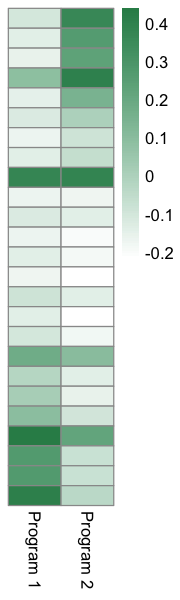

In [89]:
options(repr.plot.width=1.5, repr.plot.height=5)
pheatmap(recovered_dictionary[(order(recovered_dictionary[,1]-recovered_dictionary[,2])),], cluster_cols = F, cluster_rows = F, 
    colorRampPalette(c( "white","seagreen"))(100), width = 2, height = 10)
pheatmap(recovered_dictionary[(order(recovered_dictionary[,1]-recovered_dictionary[,2])),], cluster_cols = F, cluster_rows = F, 
    colorRampPalette(c( "white","seagreen"))(100), width = 1.5, height = 5,filename =  "./output/synthetic_data/dictionary_out.pdf")

### Example perturbation

In [90]:
# random normal vector length 25
p1 <- rnorm(25, sd = 0.7)
p2 <- rnorm(25, sd = 0.7)
p3  <- rnorm(25, sd = 0.7)
p4 <- rnorm(25, sd = 0.7)

In [94]:
options(repr.plot.width=1, repr.plot.height=5)
pheatmap(p1, cluster_cols = F, cluster_rows = F, 
    colorRampPalette(c( "white","seagreen"))(100), width = 1, height = 5,,filename =  "./output/synthetic_data/p1.pdf")
pheatmap(p2, cluster_cols = F, cluster_rows = F, 
    colorRampPalette(c( "white","seagreen"))(100), width = 1, height = 5,,filename =  "./output/synthetic_data/p2.pdf")
pheatmap(p3, cluster_cols = F, cluster_rows = F,
    colorRampPalette(c( "white","seagreen"))(100), width = 1, height = 5,,filename =  "./output/synthetic_data/p3.pdf")
pheatmap(p4, cluster_cols = F, cluster_rows = F,
    colorRampPalette(c( "white","seagreen"))(100), width = 1, height = 5,,filename =  "./output/synthetic_data/p4.pdf")

In [95]:
x = .67 * p1 - .44 * p2 + .31 * p3 + .12 * p4
pheatmap(x, cluster_cols = F, cluster_rows = F, 
    colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name = "PuOr")))(100), width = 1, height = 5,,filename =  "./output/synthetic_data/example.pdf")